**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_1_)    
  - [Preprocessing](#toc1_2_)    
    - [Standardize](#toc1_2_1_)    
    - [Dataset Split](#toc1_2_2_)    
  - [Utilities](#toc1_3_)    
    - [Summary](#toc1_3_1_)    
    - [Plots](#toc1_3_2_)    
    - [Dataloaders](#toc1_3_3_)    
  - [Shallow MLP](#toc1_4_)    
    - [Params](#toc1_4_1_)    
    - [Model](#toc1_4_2_)    
    - [Single train](#toc1_4_3_)    
    - [Plots](#toc1_4_4_)    
    - [Grid search](#toc1_4_5_)    
  - [DeepMLP](#toc1_5_)    
    - [Model](#toc1_5_1_)    
    - [Params](#toc1_5_2_)    
    - [Plots](#toc1_5_3_)    
  - [LSTM](#toc1_6_)    
    - [Model](#toc1_6_1_)    
    - [Params](#toc1_6_2_)    
    - [Train](#toc1_6_3_)    
    - [Plots](#toc1_6_4_)    
    - [Grid Search](#toc1_6_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports](#toc0_)

In [29]:
import pandas as pd
import numpy as np
import random
import csv
import time

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from codecarbon import track_emissions

In [3]:
seed =42
# Set the seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)
generator = torch.Generator().manual_seed(seed)

## <a id='toc1_2_'></a>[Preprocessing](#toc0_)

In [4]:
df = pd.read_excel('..//HeartFailure.xlsx')
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
print(df['HeartDisease'].value_counts())

1    508
0    410
Name: HeartDisease, dtype: int64


In [6]:
for col in df.columns:
    if df[col].dtypes =='O':
        df[col] = pd.Categorical(df[col]).codes

df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


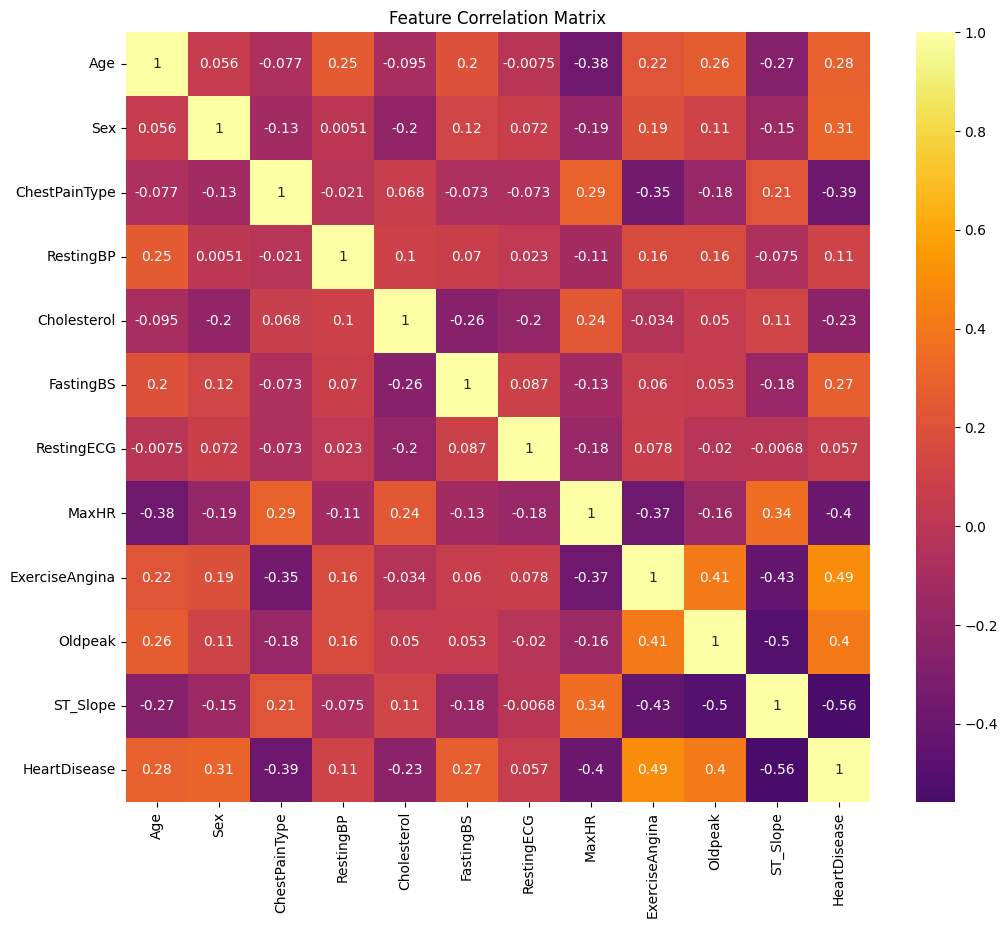

In [7]:
corr_matrix = df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='inferno', center=0)
plt.title('Feature Correlation Matrix')
plt.show()



### <a id='toc1_2_1_'></a>[Standardize](#toc0_)

In [8]:
# Select the columns to be standardized
columns_to_standardize = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Create a StandardScaler object
scaler = StandardScaler()

# Standardize the selected columns
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

### <a id='toc1_2_2_'></a>[Dataset Split](#toc0_)

In [8]:
'''
def split_data_lstm(df,lstm=False):
    #Split the dataset into training and testing sets
    X = df.drop('HeartDisease', axis=1).values
    y = df['HeartDisease'].values

    if lstm:
        X = X.reshape((X.shape[0], 1, X.shape[1]))
        #y_tensor = torch.tensor(y, dtype=torch.long).unsqueeze(1)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    else:
        # Convert data to PyTorch tensors
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    X_tensor = torch.tensor(X, dtype=torch.float32)
    # Split data into training and test sets
    dataset = TensorDataset(X_tensor, y_tensor)
    train_val_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_val_size

    val_size = int(0.2 * train_val_size)  # 20% of the training data for validation
    train_size = train_val_size - val_size

    train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size],generator=generator)
    train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size],generator=generator)
    

    return train_dataset, val_dataset, test_dataset
'''

"\ndef split_data_lstm(df,lstm=False):\n    #Split the dataset into training and testing sets\n    X = df.drop('HeartDisease', axis=1).values\n    y = df['HeartDisease'].values\n\n    if lstm:\n        X = X.reshape((X.shape[0], 1, X.shape[1]))\n        #y_tensor = torch.tensor(y, dtype=torch.long).unsqueeze(1)\n        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)\n    else:\n        # Convert data to PyTorch tensors\n        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)\n\n    X_tensor = torch.tensor(X, dtype=torch.float32)\n    # Split data into training and test sets\n    dataset = TensorDataset(X_tensor, y_tensor)\n    train_val_size = int(0.8 * len(dataset))\n    test_size = len(dataset) - train_val_size\n\n    val_size = int(0.2 * train_val_size)  # 20% of the training data for validation\n    train_size = train_val_size - val_size\n\n    train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size],generator=generator)\n    tr

In [9]:


def split_data(df):
    # Split the dataset into features (X) and labels (y)
    X = df.drop('HeartDisease', axis=1).values
    y = df['HeartDisease'].values

    # Split data into training, validation, and test sets with stratification
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    train_val_indices, test_indices = next(sss.split(X, y))
    
    X_train_val, X_test = X[train_val_indices], X[test_indices]
    y_train_val, y_test = y[train_val_indices], y[test_indices]
    
    sss_inner = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=seed)
    train_indices, val_indices = next(sss_inner.split(X_train_val, y_train_val))
    
    X_train, X_val = X_train_val[train_indices], X_train_val[val_indices]
    y_train, y_val = y_train_val[train_indices], y_train_val[val_indices]

    # Print label distributions
    print(f"Training label distribution: {np.bincount(y_train.flatten().astype(int))}")
    print(f"Validation label distribution: {np.bincount(y_val.flatten().astype(int))}")
    print(f"Test label distribution: {np.bincount(y_test.flatten().astype(int))}")

    # Convert splits to PyTorch tensors
    train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
    val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))
    test_tensor = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32).unsqueeze(1))

    return train_tensor, val_tensor, test_tensor


## <a id='toc1_3_'></a>[Utilities](#toc0_)

### <a id='toc1_3_1_'></a>[Summary](#toc0_)

In [70]:
def summary(model, input_size, batch_size=-1, device="cuda"):
    """
    Print a summary of the PyTorch model.
    
    Args:
        model (torch.nn.Module): The PyTorch model.
        input_size (tuple): The input size of the model (e.g., (3, 224, 224) for an image with 3 channels and size 224x224).
        batch_size (int): The batch size. Set to -1 for dynamic batch size.
        device (str): The device to run the model on ("cuda" or "cpu").
    """
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = "%s-%i" % (class_name, module_idx + 1)
            summary[m_key] = OrderedDict()
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size
            if isinstance(output, (list, tuple)):
                summary[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                summary[m_key]["output_shape"] = list(output.size())
            params = 0
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                summary[m_key]["trainable"] = module.weight.requires_grad
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]["nb_params"] = params

        if not isinstance(module, nn.Sequential) and not isinstance(
            module, nn.ModuleList
        ):
            hooks.append(module.register_forward_hook(hook))

    #device = device.lower()
    assert device in [
        "cuda",
        "cpu",
    ], "Input device is not valid, please specify 'cuda' or 'cpu'"

    if device == "cuda" and torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    # multiple inputs to the network
    if isinstance(input_size[0], (list, tuple)):
        x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
    else:
        x = torch.rand(2, *input_size).type(dtype)

    # create properties
    summary = OrderedDict()
    hooks = []

    # register hook
    model.apply(register_hook)

    # make a forward pass
    if isinstance(x, list):
        model(*x)
    else:
        model(x)

    # remove these hooks
    for h in hooks:
        h.remove()

    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
    print(line_new)
    print("================================================================")
    total_params = 0
    trainable_params = 0
    for layer in summary:
        # input_shape, output_shape, trainable, nb_params
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"]),
        )
        total_params += summary[layer]["nb_params"]
        if "trainable" in summary[layer]:
            if summary[layer]["trainable"] == True:
                trainable_params += summary[layer]["nb_params"]
        print(line_new)

    print("================================================================")
    print("Total params: {0:,}".format(total_params))
    print("Trainable params: {0:,}".format(trainable_params))
    print("Non-trainable params: {0:,}".format(total_params - trainable_params))
    print("----------------------------------------------------------------")


### Count Parameters

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### <a id='toc1_3_2_'></a>[Plots](#toc0_)

In [10]:
# Function to plot the losses

def plot_losses(train_losses, val_losses, dict_params):
    hyperparameters = ', '.join(f'{key}:{value}' for key, value in dict_params.items())
    
    plt.figure() 
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.text(0.5,  min(plt.ylim()) - 0.55, hyperparameters, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    plt.legend()
    plt.show()

# Function to plot the losses
def save_plot_losses(train_losses, val_losses, params: dict, namefig):
    
    items = list(params.items())
    mid_index = len(items) // 2

    first_half = items[:mid_index]
    second_half = items[mid_index:]

    hyperparameters = ', '.join(f'{key}:{value}' for key, value in first_half)
    hyperparameters2 = ', '.join(f'{key}:{value}' for key, value in second_half)

    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.text(0.5,  min(plt.ylim()) - 0.55, hyperparameters, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.5,  min(plt.ylim()) - 0.6, hyperparameters2, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    plt.legend()
    plt.savefig(namefig, bbox_inches='tight')

In [11]:
# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

### <a id='toc1_3_3_'></a>[Dataloaders](#toc0_)

In [58]:
# Create DataLoaders
def dataLoad(train_dataset, val_dataset, test_dataset, batch_size, generator):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, generator=generator)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=generator)
    return train_loader, val_loader, test_loader


## <a id='toc1_4_'></a>[Shallow MLP](#toc0_)

### <a id='toc1_4_2_'></a>[Model](#toc0_)

In [59]:
# Define the simplest MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size,hidden_layer_dim, dropout_prob=0.5):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_dim)  
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_layer_dim, 1)  
        self.sigmoid = nn.Sigmoid()
        
        torch.manual_seed(seed) 
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Function to train the model
#@track_emissions
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, printing = True):
    
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
         # Validation loss
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        
        if printing:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_train_loss:.4f}')
    return train_losses, val_losses

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)  # Calculate F1 score
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    return accuracy, f1


### <a id='toc1_4_1_'></a>[Params](#toc0_)

In [60]:
mlp_params_grid = {
    'num_epochs': [30,50,70],
    'hidden_layer_dim': [8,16,32,64],
    'batch_size': [8,16,32,64],
    'lr': [0.001, 0.01, 0.1],
    'dropout_prob': 0.4
}
mlp_params ={
    'num_epochs': [70],
    'hidden_layer_dim': [16],
    'batch_size': [8],
    'lr': [0.001],
    'dropout_prob': 0.4
}
#Number of paramters are 209

input_size = (df.drop('HeartDisease', axis=1).values).shape[1]

csv_file = '..//Grid_results//MLP//MLP_results_1.csv'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [61]:
train_dataset, val_dataset, test_dataset = split_data(df)

Training label distribution: [246 304]
Validation label distribution: [ 82 102]
Test label distribution: [ 82 102]


### <a id='toc1_4_5_'></a>[Grid search](#toc0_)

In [64]:
#@track_emissions
def mlp_grid_search(csv_file, params:dict, train_dataset, val_dataset, test_dataset):
    # Open the CSV file in write mode
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header row
        writer.writerow(['epochs', 'hidden layer dim', 'batch size', 'lr', 'test accuracy','test f1','num params','exec time'])


        for epoch in params['num_epochs']:
            for hidden_layer_dim in params['hidden_layer_dim']:
                for batch_size in params['batch_size']:
                    for lr in params['lr']:
                        print(f'num_epochs: {epoch}, hidden_layer_dim: {hidden_layer_dim}, batch_size: {batch_size}, lr: {lr}')

                        # Load the data
                        train_loader, val_loader, test_loader = dataLoad(train_dataset, val_dataset, test_dataset, batch_size, generator)
                        
                        # Initialize model, criterion, and optimizer
                        model = SimpleMLP(input_size,hidden_layer_dim, params['dropout_prob'])
                        criterion = nn.BCELoss()
                        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

                        # Train and evaluate the model
                        start_time = time.time()
                        train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epoch, printing=False)
                        test_acc, test_f1 = evaluate_model(model, test_loader)
                        end_time = time.time()
                        
                        exec_time = end_time - start_time
                        num_params = count_parameters(model)
                        
                        writer.writerow([epoch, hidden_layer_dim, batch_size, lr, test_acc, test_f1, num_params, exec_time])
                        
                        run_params = {
                            'model': 'MLP',
                            'num_epochs': epoch,
                            'hidden_layer_dim': hidden_layer_dim,
                            'batch_size': batch_size,
                            'lr': lr,
                            'dropout_prob': params['dropout_prob'],
                            'accuracy': test_acc,
                            'f1': test_f1
                        }
                        
                        
                        namefig = f"..//Plots//{run_params['model']}//loss_E{epoch}_H{hidden_layer_dim}_B{batch_size}_L{str(lr).replace('.', ',')}.png"

                        save_plot_losses(train_losses, val_losses, run_params, namefig)


In [65]:
mlp_grid_search(csv_file, mlp_params_grid, train_dataset, val_dataset, test_dataset)

num_epochs: 30, hidden_layer_dim: 8, batch_size: 8, lr: 0.001
Test Accuracy: 0.8859
F1 Score: 0.8966
num_epochs: 30, hidden_layer_dim: 8, batch_size: 8, lr: 0.01
Test Accuracy: 0.8859
F1 Score: 0.9005
num_epochs: 30, hidden_layer_dim: 8, batch_size: 8, lr: 0.1
Test Accuracy: 0.8696
F1 Score: 0.8846
num_epochs: 30, hidden_layer_dim: 8, batch_size: 16, lr: 0.001
Test Accuracy: 0.8804
F1 Score: 0.8922
num_epochs: 30, hidden_layer_dim: 8, batch_size: 16, lr: 0.01
Test Accuracy: 0.8533
F1 Score: 0.8744
num_epochs: 30, hidden_layer_dim: 8, batch_size: 16, lr: 0.1
Test Accuracy: 0.7337
F1 Score: 0.7101
num_epochs: 30, hidden_layer_dim: 8, batch_size: 32, lr: 0.001
Test Accuracy: 0.8804
F1 Score: 0.8911
num_epochs: 30, hidden_layer_dim: 8, batch_size: 32, lr: 0.01
Test Accuracy: 0.8587
F1 Score: 0.8774
num_epochs: 30, hidden_layer_dim: 8, batch_size: 32, lr: 0.1
Test Accuracy: 0.8207
F1 Score: 0.8520
num_epochs: 30, hidden_layer_dim: 8, batch_size: 64, lr: 0.001
Test Accuracy: 0.8424
F1 Score:

C:\Users\Luca\AppData\Local\Temp\ipykernel_20596\322036718.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


num_epochs: 30, hidden_layer_dim: 16, batch_size: 64, lr: 0.001
Test Accuracy: 0.8859
F1 Score: 0.8966
num_epochs: 30, hidden_layer_dim: 16, batch_size: 64, lr: 0.01
Test Accuracy: 0.8804
F1 Score: 0.8942
num_epochs: 30, hidden_layer_dim: 16, batch_size: 64, lr: 0.1
Test Accuracy: 0.8533
F1 Score: 0.8732
num_epochs: 30, hidden_layer_dim: 32, batch_size: 8, lr: 0.001
Test Accuracy: 0.8913
F1 Score: 0.9029
num_epochs: 30, hidden_layer_dim: 32, batch_size: 8, lr: 0.01
Test Accuracy: 0.8641
F1 Score: 0.8731
num_epochs: 30, hidden_layer_dim: 32, batch_size: 8, lr: 0.1
Test Accuracy: 0.8478
F1 Score: 0.8716
num_epochs: 30, hidden_layer_dim: 32, batch_size: 16, lr: 0.001
Test Accuracy: 0.8804
F1 Score: 0.8922
num_epochs: 30, hidden_layer_dim: 32, batch_size: 16, lr: 0.01
Test Accuracy: 0.8696
F1 Score: 0.8824
num_epochs: 30, hidden_layer_dim: 32, batch_size: 16, lr: 0.1
Test Accuracy: 0.8478
F1 Score: 0.8641
num_epochs: 30, hidden_layer_dim: 32, batch_size: 32, lr: 0.001
Test Accuracy: 0.8859

In [39]:
results = pd.read_csv(csv_file)
max_test_accuracy_row = results.loc[results['test accuracy'].idxmax()]
print(max_test_accuracy_row)

epochs               70.000000
hidden layer dim     32.000000
batch size           64.000000
lr                    0.010000
test accuracy         0.902174
test f1               0.913462
num params          417.000000
exec time             1.251194
Name: 130, dtype: float64


In [41]:
#print png file
namefig = f"..//Plots//MLP//loss_E{int(max_test_accuracy_row['epochs'])}_H{int(max_test_accuracy_row['hidden layer dim'])}_B{int(max_test_accuracy_row['batch size'])}_L{str(max_test_accuracy_row['lr']).replace('.', ',')}.png"


def print_png(filename):
    image = Image.open(filename)
    image.show()
    
print(namefig)

..//Plots//MLP//loss_E70_H32_B64_L0,01.png


## <a id='toc1_5_'></a>[DeepMLP](#toc0_)

### <a id='toc1_5_1_'></a>[Model](#toc0_)

In [8]:
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_layer_dims, dropout_prob=0.5):
        super(DeepMLP, self).__init__()
        
        layers = []
        current_input_size = input_size
        
        for hidden_dim in hidden_layer_dims:
            layers.append(nn.Linear(current_input_size, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            current_input_size = hidden_dim
        
        layers.append(nn.Linear(current_input_size, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, printing=True):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # Validation loss
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        
        if printing:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
    return train_losses, val_losses

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)  # Calculate F1 score
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    return accuracy, f1


### <a id='toc1_5_2_'></a>[Params](#toc0_)

In [130]:
input_size = 11
hidden_layer_dims = [32, 16, 16]#[24,32,16,8,1]
batch_size_d = 8
dropout_prob_d = 0.3
lr_d = 0.0001
num_epochs_d = 200


In [131]:
train_loader_d, val_loader_d, test_loader_d = dataLoad(train_dataset, val_dataset, test_dataset, batch_size_d, generator)

In [132]:
# Initialize model, criterion, and optimizer
model_deep = DeepMLP(input_size, hidden_layer_dims, dropout_prob)
criterion_d = nn.BCELoss()
optimizer_d = optim.Adam(model_deep.parameters(), lr=lr_d,weight_decay=1e-4)

# Train and evaluate the model
train_losses_d, val_losses_d = train_model(model_deep, train_loader_d, val_loader_d,criterion_d, optimizer_d, num_epochs_d)
delta_loss_d = abs(val_losses_d[-1] - train_losses_d[-1])
test_acc_d, test_f1_d = evaluate_model(model_deep, test_loader_d)

Epoch 1/200, Loss: 0.7123, Val Loss: 0.7089
Epoch 2/200, Loss: 0.7132, Val Loss: 0.7060
Epoch 3/200, Loss: 0.7067, Val Loss: 0.7036
Epoch 4/200, Loss: 0.7050, Val Loss: 0.7004
Epoch 5/200, Loss: 0.7052, Val Loss: 0.6980
Epoch 6/200, Loss: 0.7011, Val Loss: 0.6955
Epoch 7/200, Loss: 0.6976, Val Loss: 0.6929
Epoch 8/200, Loss: 0.6941, Val Loss: 0.6902
Epoch 9/200, Loss: 0.6975, Val Loss: 0.6880
Epoch 10/200, Loss: 0.6900, Val Loss: 0.6854
Epoch 11/200, Loss: 0.6869, Val Loss: 0.6821
Epoch 12/200, Loss: 0.6812, Val Loss: 0.6790
Epoch 13/200, Loss: 0.6789, Val Loss: 0.6756
Epoch 14/200, Loss: 0.6751, Val Loss: 0.6718
Epoch 15/200, Loss: 0.6809, Val Loss: 0.6681
Epoch 16/200, Loss: 0.6767, Val Loss: 0.6642
Epoch 17/200, Loss: 0.6797, Val Loss: 0.6605
Epoch 18/200, Loss: 0.6704, Val Loss: 0.6558
Epoch 19/200, Loss: 0.6673, Val Loss: 0.6507
Epoch 20/200, Loss: 0.6627, Val Loss: 0.6455
Epoch 21/200, Loss: 0.6596, Val Loss: 0.6399
Epoch 22/200, Loss: 0.6465, Val Loss: 0.6330
Epoch 23/200, Loss:

### <a id='toc1_5_3_'></a>[Plots](#toc0_)

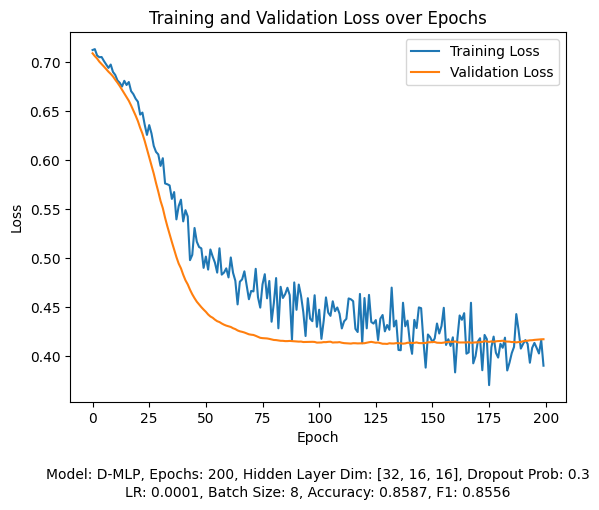

In [133]:
params_d = {
    'epochs': num_epochs_d,
    'hidden_layer_dim': hidden_layer_dims,
    'batch_size': batch_size_d,
    'lr': lr_d,
    'dropout': dropout_prob_d,
    'accuracy': test_acc_d,
    'f1': test_f1_d,
    'model': 'D-MLP'
}
save_plot_losses(train_losses_d, val_losses_d,params_d)

## <a id='toc1_6_'></a>[LSTM](#toc0_)

### <a id='toc1_6_1_'></a>[Model](#toc0_)

In [15]:
# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size,dropout_prob=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()
    
    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        x.unsqueeze_(1)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    model.train()
    
    for epoch in range(num_epochs):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        # Training phase
        model.train()
        for features, labels in train_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        train_losses.append(epoch_train_loss / len(train_loader))
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(device)
                labels = labels.to(device)
                
                outputs = model(features)
                
                loss = criterion(outputs, labels)
                
                epoch_val_loss += loss.item()
        
        val_losses.append(epoch_val_loss / len(val_loader))
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')
        
    
    return train_losses, val_losses

# Function to evaluate the model
def evaluate_model(model, test_loader,device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            probabilities = torch.sigmoid(outputs)
            predicted = (probabilities > 0.5).float()  # Apply threshold
            #_, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    return accuracy, f1, precision, recall, y_true, y_pred


### <a id='toc1_6_2_'></a>[Params](#toc0_)

In [20]:
# Model parameters
lstm_params_grid = {
    'input_size' : 11,
    'hidden_size' : [16,32,64],
    'num_layers' : [1,2,4],
    'output_size' : 1 , # Binary classification
    'num_epochs' : [50,100],
    'learning_rate' : [0.0001, 0.0005 ,0.001],
    'batch_size' : [8,16,32],
    'dropout_prob' : 0.4
}
lstm_params = {
    'input_size' : 11,
    'hidden_size' : [32],
    'num_layers' : [2],
    'output_size' : 1 , # Binary classification
    'num_epochs' : [100],
    'learning_rate' : [0.0001],
    'batch_size' : [8],
    'dropout_prob' : 0.4
}

# Define the path to the CSV file
lstm_csv_file = '..//Grid_results//LSTM//results_6.csv'


In [16]:
train_dataset_lstm, val_dataset_lstm, test_dataset_lstm = split_data(df)

Training label distribution: [246 304]
Validation label distribution: [ 82 102]
Test label distribution: [ 82 102]


### <a id='toc1_6_5_'></a>[Grid Search](#toc0_)

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
CODECARBON : Failed to match CPU TDP constant. Falling back on a global constant.


Epoch [1/100], Train Loss: 0.6901, Validation Loss: 0.6908
Epoch [2/100], Train Loss: 0.6887, Validation Loss: 0.6896
Epoch [3/100], Train Loss: 0.6872, Validation Loss: 0.6883
Epoch [4/100], Train Loss: 0.6865, Validation Loss: 0.6871
Epoch [5/100], Train Loss: 0.6851, Validation Loss: 0.6857
Epoch [6/100], Train Loss: 0.6832, Validation Loss: 0.6843
Epoch [7/100], Train Loss: 0.6803, Validation Loss: 0.6829
Epoch [8/100], Train Loss: 0.6796, Validation Loss: 0.6814
Epoch [9/100], Train Loss: 0.6786, Validation Loss: 0.6797
Epoch [10/100], Train Loss: 0.6753, Validation Loss: 0.6779
Epoch [11/100], Train Loss: 0.6742, Validation Loss: 0.6760
Epoch [12/100], Train Loss: 0.6705, Validation Loss: 0.6739
Epoch [13/100], Train Loss: 0.6701, Validation Loss: 0.6716
Epoch [14/100], Train Loss: 0.6655, Validation Loss: 0.6691
Epoch [15/100], Train Loss: 0.6620, Validation Loss: 0.6664
Epoch [16/100], Train Loss: 0.6604, Validation Loss: 0.6635
Epoch [17/100], Train Loss: 0.6556, Validation Lo

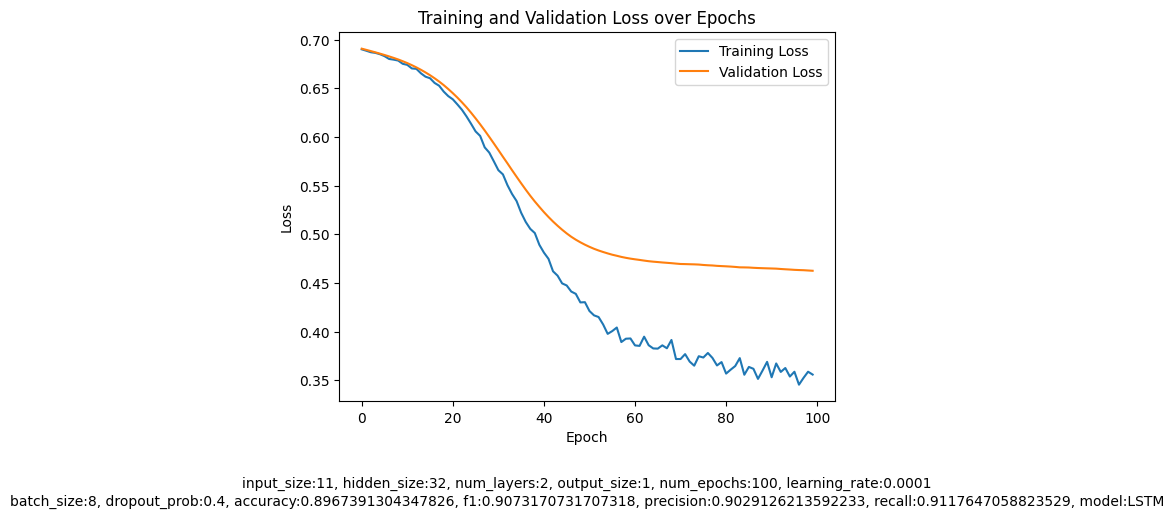

In [43]:
#@track_emissions
def grid_search(lstm_csv_file, params:dict, train_dataset, val_dataset, test_dataset):
    # Open the CSV file in write mode
    with open(lstm_csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header row
        writer.writerow(['num_epochs', 'hidden_size', 'num_layers', 'batch_size', 'lr', 'test_accuracy','test_f1','precision','recall','exec_time','params','y_true','y_pred'])
        
        for epochs in params['num_epochs']:
            for hidden_size in params['hidden_size']:
                for num_layers in params['num_layers']:
                    for batch_size in params['batch_size']:
                        for lr in params['learning_rate']:
                            
                            # Load data
                            train_loader, val_loader, test_loader = dataLoad(train_dataset, val_dataset, test_dataset, lstm_params['batch_size'], generator)
                            # Initialize the model, loss function, and optimizer
                            model = LSTMModel(params['input_size'], hidden_size, num_layers,  params['output_size'])
                            criterion = nn.BCEWithLogitsLoss()
                            optimizer = optim.Adam(model.parameters(), lr= lr,weight_decay=1e-4)

                            # Device configuration
                            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                            model = model.to(device)

                            start_time = time.time()
                            train_losses, val_losses = train_model(model, train_loader, val_loader ,criterion, optimizer, epochs, device)
                            test_acc, test_f1, precision, recall, y_true, y_pred = evaluate_model(model, test_loader,device)
                            end_time = time.time()
                            
                            exec_time = end_time - start_time
                            num_param = count_parameters(model)
                            run_params ={
                                'model': 'LSTM',
                                'hidden_size' : hidden_size,
                                'num_layers' : num_layers,
                                'num_epochs' : epochs,
                                'learning_rate' : lr,
                                'batch_size' : batch_size,
                                'accuracy': test_acc,
                                'f1': test_f1,
                                'precision': precision,
                                'recall': recall
                            }
                            
        
                            namefig = f"..//Plots//{run_params['model']}//loss_E{epochs}_H{hidden_size}_NL{num_layers}_B{batch_size}_L{str(lr).replace('.', ',')}.png"

                            save_plot_losses(train_losses, val_losses, run_params, namefig)
                            writer.writerow([epochs, hidden_size, num_layers, batch_size, lr, test_acc, test_f1, precision, recall, exec_time, num_param, y_true, y_pred])             

In [ ]:
grid_search(lstm_csv_file, lstm_params_grid,train_dataset_lstm, val_dataset_lstm, test_dataset_lstm)

In [58]:
results = pd.read_csv(lstm_csv_file)
results = results.drop(['y_true', 'y_pred'], axis=1)
# Assuming the DataFrame variable is named 'df'
max_accuracy_row = results[results['test_accuracy'] == results['test_accuracy'].max()]

print("Row with maximum accuracy:")
print(max_accuracy_row)

Row with maximum accuracy:
     num_epochs  hidden_size  num_layers  batch_size      lr  test_accuracy  \
117         100           32           2           8  0.0001       0.896739   
135         100           64           1           8  0.0001       0.896739   

      test_f1  precision    recall  
117  0.907317   0.902913  0.911765  
135  0.907317   0.902913  0.911765  


### <a id='toc1_6_4_'></a>[Plots](#toc0_)

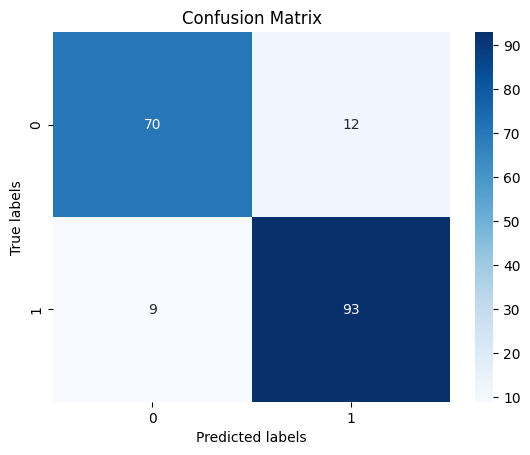

In [ ]:
plot_confusion_matrix(y_true, y_pred, 'Confusion Matrix')